# Predicting Car Prices Using K-nearest Neighbors Regressions

## Introduction
---
From a car listing data set we train several k-nearest neighbor regression models which try to predict the price of cars, based on their technical specifications.


The data set has been compiled from the 1985 Ward's 'Automotive Yearbook' and is accessible in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/automobile). 

## Data Set Information
---

From the data source:



> This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars. The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.   


> The third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.






### Column description

#### Attribute: Attribute Range


1. `symboling`: -3, -2, -1, 0, 1, 2, 3.
2. `normalized-losses`: continuous from 65 to 256.
3. `make`:
alfa-romero, audi, bmw, chevrolet, dodge, honda,
isuzu, jaguar, mazda, mercedes-benz, mercury,
mitsubishi, nissan, peugot, plymouth, porsche,
renault, saab, subaru, toyota, volkswagen, volvo

4. `fuel-type`: diesel, gas.
5. `aspiration`: std, turbo.
6. `num-of-doors`: four, two.
7. `body-style`: hardtop, wagon, sedan, hatchback, convertible.
8. `drive-wheels`: 4wd, fwd, rwd.
9. `engine-location`: front, rear.
10. `wheel-base`: continuous from 86.6 120.9.
11. `length`: continuous from 141.1 to 208.1.
12. `width`: continuous from 60.3 to 72.3.
13. `height`: continuous from 47.8 to 59.8.
14. `curb-weight`: continuous from 1488 to 4066.
15. `engine-type`: dohc, dohcv, l, ohc, ohcf, ohcv, rotor.
16. `num-of-cylinders`: eight, five, four, six, three, twelve, two.
17. `engine-size`: continuous from 61 to 326.
18. `fuel-system`: 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi.
19. `bore`: continuous from 2.54 to 3.94.
20. `stroke`: continuous from 2.07 to 4.17.
21. `compression-ratio`: continuous from 7 to 23.
22. `horsepower`: continuous from 48 to 288.
23. `peak-rpm`: continuous from 4150 to 6600.
24. `city-mpg`: continuous from 13 to 49.
25. `highway-mpg`: continuous from 16 to 54.
26. `price`: continuous from 5118 to 45400.

Note: we'll be using the terms (independent/explanatory) 'variable' and 'attribute' interchangeably, to describe the cars' technical specs. 

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

### The Data Set And Basic Information

Note: the data set and its index are not in the same file, so we read the index first and plug it into the main DataFrame while reading it. 

In [2]:
cars_index = pd.read_csv('imports-85_column_index.csv', header=None, names=['cols'])

cars = pd.read_csv('imports-85.data', header=None, names=cars_index['cols'])

Inspecting the first 5 rows.

In [3]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinder    205 non-null    object 
 16  engine-size        205 non

Based on the information in `cars.head()` and `cars.info()`, we can already identify some issues to account for:
- some attributes such as `normalized-losses` are numeric in nature but are set as type `object`, therefore we need to do some data cleaning.
- Besides `price`, which is our dependent variable, there are 25 possible explanatory variables to choose from, that should be siphoned through using some criteria, in order to understand if it makes sense to used them as explanatory variables.     

## Data Cleaning 
---
The preparation tasks will be:

- Convert objects into floats.
- Deal with missing values. 
- Transform or manipulate attributes if needed.
- Rescale the values in the numeric columns so they all range from 0 to 1.


First task:
1. Replacing all `?` values in the `cars` for `np.nan`.
2. Replace values in `num-of-doors` - 'two', 'four', for numeric values.
3. Same for `num-of-cylinder` as in 2. convert numbers from written to numeric form.
4. Convert also these attributes from object to float type:
    - `normalized-losses`,
    - `bore`,
    - `stroke`,
    - `horsepower`,
    - `peak-rpm`,
    - `price`.

In [5]:
# 1.
cars = cars.replace('\?', np.nan, regex=True)

# 2.
cars['num-of-doors'] = cars['num-of-doors'].replace('two', 2)
cars['num-of-doors'] = cars['num-of-doors'].replace('four', 4)


# 3.
unique_cyls = cars['num-of-cylinder'].unique()

conv_list = [4, 6, 5, 3, 12, 2, 8]

cylinders_conv_dict = {unique_cyls[index]: val for index, val in enumerate(conv_list)}

cars['num-of-cylinder'] = cars['num-of-cylinder'].replace(cylinders_conv_dict)


# 4.
sel_conv_type = [
    'normalized-losses',
    'num-of-cylinder',
    'bore',
    'stroke',
    'horsepower',
    'peak-rpm',
    'price'
] 

conv_type_dict = {col: float for col in sel_conv_type}

cars = cars.astype(conv_type_dict)

## Choosing The Attributes

---
Since we're about to use a regression, we'll be using only quantitative variables in this analysis. The group of variables below will be the starting point:


- `symboling`
- `normalized-losses`
- `num-of-doors`
- `length`
- `width`
- `height`
- `curb-weight`
- `num-of-cylinder`
- `engine-size`
- `bore`
- `stroke`
- `compression-ratio`
- `horsepower`
- `peak-rpm`
- `city-mpg`
- `highway-mp`
       
It is worth mention that we are skipping in this analysis, potentially relevant categorical data, such as the car brand, fuel type, etc. For now, we narrow down the selection of attributes to those mentioned above, storing them in `cars_2`. Then we deal with the missing values case-by-case.

In [6]:
to_keep = [col for col in cars.columns if pd.api.types.is_numeric_dtype(cars[col])]

cars_2 = cars[to_keep]

Checking missing values by column/attribute:


In [7]:
cars_2.isna().sum()

symboling             0
normalized-losses    41
num-of-doors          2
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
num-of-cylinder       0
engine-size           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

#### How each attribute will be dealt with, regarding the missing values:



1. We drop `normalized-losses` since 20% of its values are missing, (such a portion of the data can be considered too large to average out).
   
   
2. Replacing the missing values in `num-of-doors` by the most common value found for the type of 'body-style' of those particular listings.
   
   
3. Dropping the `wheel-base` based on the assumption that other specifications, such as the size or the weight of the car, can be much more effective in establishing a relation between an indirect measure of input cost - a bigger or heavier car is expected to have more material spent on its materialization, and subsequently, in the final sale price.
   
   
4. Replacing (dropping) `lenght`, `width` and `height` by the volume of the car (a new column named `size`) which is the multiplication of these three columns.  
   
   
5. We drop for now some engine related aspects, `bore`, `stroke`, `compression-ratio` and keep the `num-of-cylinder`, `horsepower` and `peak-rpm`. We replace the missing values in these last columns by sampling the listings that have the same engine attributes that have been dropped out -`bore`, `stroke`, etc, and take out the average resorting to a series of steps described below in more detail. (We proceed this way, instead of looking for these specs online, since no attribute in the data set specifies the model, only the car brand.)
   
   
6. To fill out the missing values in `price`, we choose the attribute with the highest correlation to the sale price and perform a task similar to point 5 (explained in more detail below).

1. Dropping `normalized-losses`.

In [8]:
cars_2 = cars_2.drop(columns=['normalized-losses'])

2. Replacing the missing values in `num-of-doors`.

The listings with missing values in `num-of-doors`:

In [9]:
no_num_doors = cars[cars.loc[:, 'num-of-doors'].isna()]

no_num_doors.loc[:, ['make', 'num-of-doors', 'body-style']]

,make,num-of-doors,body-style
27,dodge,NaN,sedan
63,mazda,NaN,sedan


Let's check what is the most common number of doors for sedans and replace the missing values with it.

In [10]:
sedans = cars[cars.loc[:, 'body-style'].isin(['sedan'])]

sedans['num-of-doors'].value_counts()

4.0    79
2.0    15
Name: num-of-doors, dtype: int64

Replacing the missing values by 4 (doors) since 79 out of 94 sedans have 4 doors.

In [11]:
cars_2.loc[[27, 63], 'num-of-doors'] = 4.0

3. Dropping `wheel-base.`

In [12]:
cars_2 = cars_2.drop(columns=['wheel-base'])

4. Producing a new `size` column and dropping `length`, `width` and `height`.

In [13]:
size = cars_2['length'] * cars_2['width'] * cars_2['height']

cars_2.insert(loc=2, column='size', value=size) 

cars_2 = cars_2.drop(columns=['length', 'width', 'height'])

5. Dropping `bore`, `stroke`, `compression-ratio` while resorting to these variables to replace missing values in `horsepower` and `peak_rpm` 

In [14]:
cars_2 = cars_2.drop(columns=['bore', 'stroke', 'compression-ratio'])

We can see below that the rows for which there are no `horsepower` and `peak-rpm` values are the identical.

In [15]:
no_hp_no_rpm = cars[cars_2.loc[:, 'horsepower'].isna()]

no_hp_no_rpm.iloc[:, np.r_[2, -10:-1]]

,make,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
130,renault,132,mpfi,3.46,3.9,8.7,NaN,NaN,23,31
131,renault,132,mpfi,3.46,3.9,8.7,NaN,NaN,23,31


The next set of procedures will be used to calculate average values that fill out the respective missing values in `horsepower` and `peak-rpm`:

   
   
- collect the attributes (columns) that are likely to influence `horsepower` and `peak-rpm`. These are inserted in the list `cols`.
   
   
   
- From the table above we can see that both cars were produced by Renault and the available engine specs are identical, therefore we can assume that both cars have the same engine. 
   
   
- Then, we look at the rows/listings that are similar to the pattern exhibited by the engine spec values in row 130 (stored as `ref`). Engines usually have very specific specs, so if we search for the exact same specs in other cars we may be out of luck in finding similar listings. To circumvent this caveat, we fix the values of 'fuel-type', 'fuel-system', 'num-of-cylinder', while looking for values in engine size, bore, stroke, and compression-ratio that can vary, positively or negatively, up to 15% from the reference (values in rows 130-131). The use of this 15% threshold does not have a specific technical justification behind it, besides being an attempt to capture some values near the reference.
   

- After collecting similar listings we can average out the value for horse power and peak-rpm and place them where they are missing. 

Too calculate the missing values we work with a smaller version of the original data set named `cars_short`, being the original one `cars` and not `cars_2`.

In [16]:
cols = [
    'fuel-type',
    'fuel-system',
    'num-of-cylinder',
    'engine-size',
    'bore',
    'stroke',
    'compression-ratio'
]


cars_short = cars[cols]

Are engine specs identical in row 130 and 131?

In [17]:
cars.loc[130, cols] == cars.loc[131, cols]

fuel-type            True
fuel-system          True
num-of-cylinder      True
engine-size          True
bore                 True
stroke               True
compression-ratio    True
dtype: bool

The reference values.


In [18]:
ref = cars.loc[130, cols]

ref

fuel-type             gas
fuel-system          mpfi
num-of-cylinder       4.0
engine-size           132
bore                 3.46
stroke                3.9
compression-ratio     8.7
Name: 130, dtype: object

First we filter the listings that have the same values for `fuel-type`, `fuel-system`, `num-of-cylinder.` 

In [19]:
cars_short = cars_short[cars_short['fuel-type']=='gas']
cars_short = cars_short[cars_short['fuel-system']=='mpfi']
cars_short = cars_short[cars_short['num-of-cylinder']==4]

Now we filter the remaining version of `cars_short` by the attributes that we allow to vary by 15% from the reference values. These are:

- `engine-size`

- `bore`
- `stroke`
- `compression-ratio`

In [20]:
for i in range(3, 6+1):
    lower_bound = ref[i] - (ref[i]*0.15)
    high_bound = ref[i] + (ref[i]*0.15)
    
    col_name = ref.index[i]
    
    cars_short = cars_short[(lower_bound <= cars_short[col_name])]
    cars_short = cars_short[(cars_short[col_name] <= high_bound)]

As we can see below, the final version of `cars_short` has 12 rows: 2 are our reference rows (130 and 131) and the rest are those listings with similar engine specs. 


In [21]:
cars_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 130 to 177
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fuel-type          12 non-null     object 
 1   fuel-system        12 non-null     object 
 2   num-of-cylinder    12 non-null     float64
 3   engine-size        12 non-null     int64  
 4   bore               12 non-null     float64
 5   stroke             12 non-null     float64
 6   compression-ratio  12 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 768.0+ bytes


We average out the values of these listings for `horsepower` and `peak-rpm`.


In [22]:
hp_rpm_means = cars.loc[cars_short.index, ['horsepower', 'peak-rpm']].mean().round(0)

hp_rpm_means

horsepower     106.0
peak-rpm      4560.0
dtype: float64

Filling out the missing values in `cars_2`.

In [23]:
cars_2.loc[[130, 131], 'horsepower'] = hp_rpm_means[0]
cars_2.loc[[130, 131], 'peak-rpm'] = hp_rpm_means[1]

Finally, we fill out the missing values of the 'price' column.

First off, we look at the correlations of each attribute vs the price.

In [24]:
correlations = cars_2.corr()

correlations = correlations.drop(columns=[i for i in cars_2.columns if i != 'price'])

correlations

,price
symboling,-0.082391
num-of-doors,0.042435
size,0.628701
curb-weight,0.834415
num-of-cylinder,0.708645
engine-size,0.872335
horsepower,0.809345
peak-rpm,-0.095600
city-mpg,-0.686571
highway-mpg,-0.704692


As expected, the `engine-size` seems to be an influential attribute, when it comes to the price of a car: 0.87, when the max. positive correlation is 1. Now, we can proceed as explained earlier, by performing a task similar to the previous one, regarding `horsepower` and `peak-rpm`.

The rows with missing values

In [25]:
price_missing = cars[cars_2.loc[:, 'price'].isna()]

price_missing[['make', 'engine-size', 'price']]

,make,engine-size,price
9,audi,131,NaN
44,isuzu,90,NaN
45,isuzu,90,NaN
129,porsche,203,NaN


Since we have to produce 3 different average prices, for three different engine sizes: 90, 131 and 203 (the description does not specify but it is probably referring to cubic inches - the data is taken from a US source), it is better to encapsulate all the steps into a function that returns the average price based on the listings that vary up to 15% from these engine sizes (the table above is our reference). 

In [26]:
def avg_price(engine_size):
    lower_bound = engine_size - (engine_size*0.15)
    high_bound = engine_size + (engine_size*0.15)
    
    interval = pd.Interval(lower_bound, high_bound, closed='both')
    
    cond = cars['engine-size'].apply(lambda x: x in interval)
    
    sample = cars[cond].copy()
    
    avg_price = sample['price'].mean()
    
    return avg_price

The average prices for each unique engine size.

In [27]:
eng_size_to_price = {value: round(avg_price(value), 0) for index, value in enumerate(price_missing['engine-size'])}

for key in eng_size_to_price:
    print(f'Engine size with {key} cubic inches: ${eng_size_to_price[key]}')

Engine size with 131 cubic inches: $13722.0
Engine size with 90 cubic inches: $7370.0
Engine size with 203 cubic inches: $26135.0


Filling out the missing price values.

In [28]:
cars_2.loc[9, 'price'] = eng_size_to_price[131]
cars_2.loc[[44, 45], 'price'] = eng_size_to_price[90]
cars_2.loc[129, 'price'] = eng_size_to_price[203]

### Normalizing All The Columns In `cars_2`


Since each attribute has its own order of magnitude it is sensible to normalize all the attributes across the data set (to the exception of the target feature - `price`)

This ends our data cleaning and preparation stage.


In [29]:
cols_to_norm = [i for i in cars_2.columns if i != 'price']

norm = cars_2.copy()

# Normalizing attributes.
norm[cols_to_norm] = (cars_2[cols_to_norm] - cars_2[cols_to_norm].min()) / (cars_2[cols_to_norm].max() - cars_2[cols_to_norm].min())

## Producing and Analyzing Different Univariate K-nearest Neighbors Models
---
First off, the current task is to build a function that allows us to fit/train an univariate K-nearest Neighbor Regression model (KNN for short) in order to predict car prices. With that model we can then use the test set to that end, returning an error metric value that allows us to evaluate the models predicting accuracy. 


Inputs:
 - Name of attribute(s) as the model's features (as a string or a list of strings).
 - The target attribute, in our case the `price` column.
 - The DataFrame from which to withdraw the data of choice.
 
Returns:
 -Root mean squared error (RMSE) between the actual `price` values in the test set and the predicted ones.
 


Preliminary notes:
- The training set will contain 75% of the values in `cars_2`.

- The remaining 25% serve as the test set.
- The randomizing of `cars_2` will be done once, and outside the function, so that we can store and load again the resulting shuffled DataFrame:

In [30]:
runs = 1

if runs == 0:
    
    runs += 1

    np.random.seed(1)

    cars_rand = norm.loc[np.random.permutation(len(norm))]

    cars_rand = cars_rand.reset_index(drop=True)

    cars_rand.to_csv('cars_rand.csv', index=False)

In [31]:
cars_rand = pd.read_csv('cars_rand.csv')

The summary information of the data set we'll be using to fit the model.

In [32]:
cars_rand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   symboling        205 non-null    float64
 1   num-of-doors     205 non-null    float64
 2   size             205 non-null    float64
 3   curb-weight      205 non-null    float64
 4   num-of-cylinder  205 non-null    float64
 5   engine-size      205 non-null    float64
 6   horsepower       205 non-null    float64
 7   peak-rpm         205 non-null    float64
 8   city-mpg         205 non-null    float64
 9   highway-mpg      205 non-null    float64
 10  price            205 non-null    float64
dtypes: float64(11)
memory usage: 17.7 KB


In [33]:
def knn_train_test(train_col, target_col, df):
    """It takes a DataFrame from which a single attribute/column is selected, and a 
    target column, in order to perform a Univariate K-nearest Neighbors prediction. 
    It returns the Root Mean Square Error between the target and the prediction.
    """

    index_split = round(df.shape[0]*0.75, 0)
    
    train = df.loc[:index_split, [train_col, target_col]].copy()
    
    series_list = train[train_col].values.tolist()
    
    train_x = np.array(series_list).reshape(-1, 1)
    
    test = df.loc[index_split:, [train_col, target_col]].copy()

    knn = KNeighborsRegressor(n_neighbors=5, algorithm='auto')

    knn.fit(train_x, train[target_col].values)
    
    prediction = knn.predict(test[[train_col]].values)
    
    mse = mean_squared_error(test[target_col], prediction)
    
    rmse = round(np.sqrt(mse), 2)
    
    return rmse    

Now that we produced the desired function we can fit an univariate model and corresponding RMSEs for each attribute in `cars_rand`.

In [34]:
cols_but_price = [i for i in cars_rand.columns if i != 'price']

rmse_dict = {i: knn_train_test(i, 'price', cars_rand) for i in cols_but_price}

rmse_s = pd.Series(rmse_dict, name='RMSEs univar')

rmse_s = rmse_s.sort_values()

rmse_s

engine-size        3607.18
curb-weight        3911.44
city-mpg           4554.14
horsepower         4597.38
highway-mpg        4652.59
num-of-cylinder    4703.62
size               7386.45
peak-rpm           8118.85
symboling          8131.79
num-of-doors       9060.07
Name: RMSEs univar, dtype: float64

When observing the compiled RMSE's in the Series above, we can see that the top 6 attributes with the smallest errors, from `engine-size` to `horsepower` are diverse in nature. Engine specifications such as horsepower and number of cylinders are performance-related, like `peak-rpm`, but this one seems less accurate in predicting car prices. Although the engine size is not _per se_ a performance specification, it may be highly correlated with it; hence the probable assumption that a big engine translates into an expensive car, where the inverse may also be true. Moreover, it appears that attributes which are somewhat related with engine performance but can be seen as a separate category - namely fuel efficiency (in miles per gallon) in city and highway context, are good predictors of car prices. Other physical car specs are scattered all over: the car's weight seems to be an important attribute, whereas size is lesser decisive as a predictor of price, and the number of doors even less. `symboling` appears at the 8th place, which means that the risk associated with the price of the car is not the most predicting factor, compared with the ones already discussed. 

### Producing Univariate Models With Different Numbers Of Neighbors 


Note: 'k' in this context is the number of values with the smallest euclidean distance which one takes into account, when calculating the average predicted value. In the previous task we left it at it's default value:

    knn = KNeighborsRegressor(n_neighbors=5, algorithm='auto')

In the line of code above 'k' is given by `n_neighbors=5`.


In this part of the analysis we add a 'k' parameter to the function `knn_train_test()`, so that we can fit and compare the same univariate models' errors but with different k values.



The new function is now called `knn_train_test_2`. 

The list of `k` values to try is: 1, 3, 5, 7, 9.


In [35]:
def knn_train_test_2(k, train_col, target_col, df):
    """It takes a DataFrame from which a single attribute/column is selected and a 
    target column in order to perform a Univariate K-nearest Neighbors prediction. The number of neighbors also needs to be specified by setting k.
    It returns the Root Mean Square Error between the target and the prediction.
    """

    index_split = round(df.shape[0]*0.75, 0)
    
    train = df.loc[:index_split, [train_col, target_col]].copy()
    
    series_list = train[train_col].values.tolist()
    
    train_x = np.array(series_list).reshape(-1, 1)
    
    test = df.loc[index_split:, [train_col, target_col]].copy()

    knn = KNeighborsRegressor(n_neighbors=k, algorithm='auto')

    knn.fit(train_x, train[target_col].values)
    
    prediction = knn.predict(test[[train_col]].values)
    
    mse = mean_squared_error(test[target_col], prediction)
    
    rmse = round(np.sqrt(mse), 2)
    
    return rmse    

In the previous task we produced a Series where the column is the RMSE and the row index is the associated attribute. We now extend that procedure to a DataFrame where each row/RMSE is associated with an element in the `k_list`, whereas each column is associated with an attribute (the DataFrame has been transposed). 


In [36]:
k_list = [1, 3, 5, 7, 9]

def rmse_univar_change_k(k_list):
    
    cols_but_price = [i for i in cars_rand.columns if i != 'price']
    
    for index, val in enumerate(cols_but_price): 

        rmse_dict = {f'{k_i}': knn_train_test_2(k_i, val, 'price', cars_rand) for k_i in k_list}

        rmse_s = pd.Series(rmse_dict)
        
        if index == 0:
            rmse_df = pd.DataFrame({f'{val}': rmse_s}).rename_axis('k')
        else:
            rmse_df.insert(rmse_df.shape[1],
                           f'{val}',
                           rmse_s,
                           True) # allow dupl.

    return rmse_df

rmse_df = rmse_univar_change_k(k_list)

rmse_df 

,symboling,num-of-doors,size,curb-weight,num-of-cylinder,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg
k,,,,,,,,,,
1,8048.97,9080.90,5393.60,4811.83,5954.77,3880.35,5533.37,7786.73,5962.57,6609.32
3,8544.74,9166.35,6461.91,4313.11,4651.03,3662.83,4833.78,8844.96,4767.01,4773.05
5,8131.79,9060.07,7386.45,3911.44,4703.62,3607.18,4597.38,8118.85,4554.14,4652.59
7,8360.85,8418.46,7286.64,3880.30,4921.90,3558.22,4640.45,8689.65,4738.93,4291.17
9,8698.56,8500.61,7224.41,3849.13,5233.51,3700.49,4657.91,9304.00,4918.32,4206.71


The graphs below allow us to better visualize the impact on the predicting accuracy (the lowest the RMSE the better) of each univariate model as we increase 'k'.

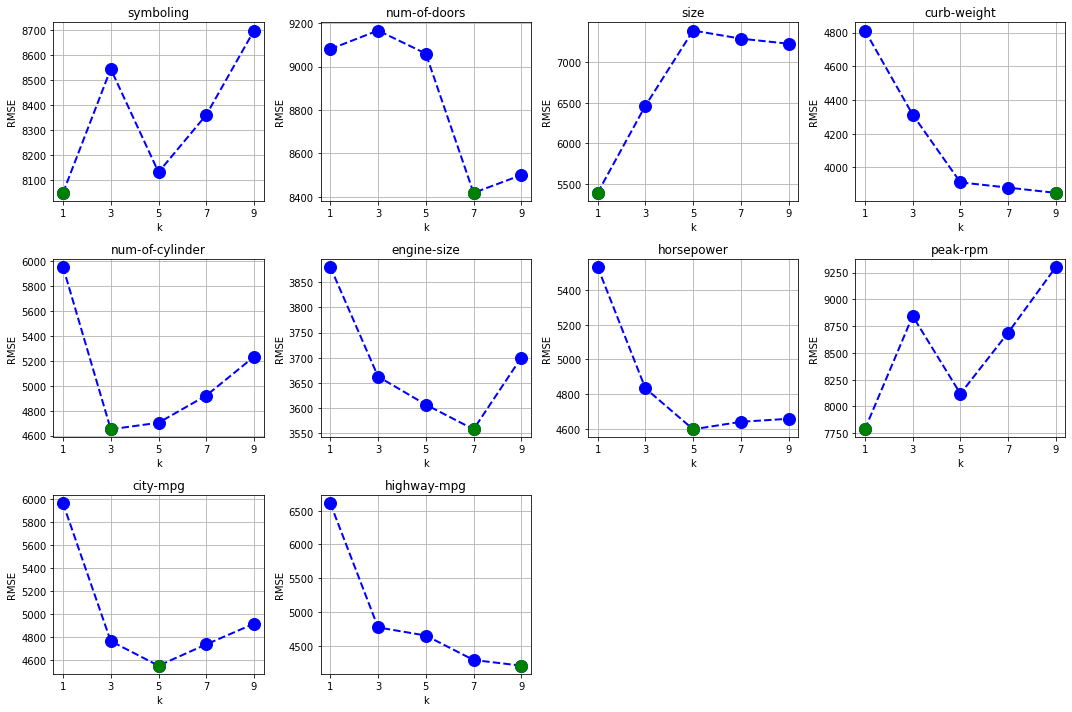

In [37]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))

for i, col in enumerate(rmse_df.columns):
    
    if i < 4:
        ax_ = ax[0, i]
    if 4 <= i < 8:
        ax_ = ax[1, i-4]
    if i >= 8:
        ax_ = ax[2, i-8]

    ax_.set_title(f'{col}')
    ax_.set_xlabel('k')
    ax_.set_ylabel('RMSE')
    ax_.grid()

    # Main graph.
    ax_.plot(
        rmse_df.index,
        rmse_df[col],
        color='blue',
        marker='o',
        linestyle='dashed',
        linewidth=2,
        markersize=12
    )

    # Minimum value marker coordinates.
    ax_.plot(
        rmse_df[col].idxmin(),
        rmse_df[col].min(),
        marker='o',
        color='green',
        markersize=12
    )
    
ax[2, 2].set_axis_off()
ax[2, 3].set_axis_off()

plt.tight_layout()
    
plt.show()

Quick take on the line graphs that put the RMSE of each attribute vs the number 'k' neighbors. The smallest RMSEs are marked as a green dot). 

Counting how many univariate models have their lowest error at a given number of neighbors ('k'):


| k | counts | features |
|---|--------|----------|
| 1 | 3      | `symboling`, `size`, `peak-rpm` |
| 3 | 1      | `num_of_cylinder`               |
| 5 | 2      | `horsepower`, `city_mpg`          |
| 7 | 2      | `num_of_doors`, `engine_size`   |
| 9 | 2      |  `curb_weight`, `city_mpg`      |

In general, there isn't a k value that universally reduces the error. 

## Fitting Multivariate KNN Models

---

In this part of the analysis we pick the the five attributes that best performed so far prediction wise (lowest RMSE), and assess whether fitting multi-variate models based on those attributes helps to increase the models' accuracy. 



The top 5 RMSE for univariate k-nearest neighbor models when `k=5`:

In [38]:
top_5 = list(rmse_s.index[:5])

top_5

['engine-size', 'curb-weight', 'city-mpg', 'horsepower', 'highway-mpg']

We are going to first, modify `knn_train_test_2()` so that it can take more than one attribute/column. The new function is called `knn_train_test_3()`. 

In [39]:
def knn_train_test_3(k, train_cols, target_col, df):
    """It takes a DataFrame from which a list of attributes/columns is selected and a 
    target column, in order to perform a Multivariate K-nearest Neighbors prediction. 
    It returns the Root Mean Square Error between the target and the prediction.
    """

    index_split = round(df.shape[0]*0.75, 0)
    
    columns = train_cols + [target_col]
    
    train = df.loc[:index_split, columns].copy()
    test = df.loc[index_split:, columns].copy()
    
    train_features = train[train_cols]
    train_target = train[target_col]

    knn = KNeighborsRegressor(n_neighbors=k, algorithm='auto')

    knn.fit(train_features, train_target)
    
    prediction = knn.predict(test[train_cols])
    
    mse = mean_squared_error(test[target_col], prediction)
    
    rmse = round(np.sqrt(mse), 2)
    
    return rmse    

The next function, `rmse_multivar_model()` is a tool that helps us to compile the RMSEs of several fitted models. The first corresponds to the univariate model with the lowest RMSE ('engine-size'), the next models are fit by adding the next attribute with the smallest univariate RMSE, and so on.


We keep the default `n_neighbors=5` for all models.

In [40]:
def rmse_multivar_model(list_cols):
    
    rmse_dict = {
        f'{list_cols[:ind+1]}': knn_train_test_3(5, list_cols[:ind+1], 'price', cars_rand) \
             for ind, val in enumerate(list_cols)
    }

    return rmse_dict


multivar_rmse_dict = rmse_multivar_model(top_5)

multivar_rmse_dict

{"['engine-size']": 3607.18,
 "['engine-size', 'curb-weight']": 2846.17,
 "['engine-size', 'curb-weight', 'city-mpg']": 2831.32,
 "['engine-size', 'curb-weight', 'city-mpg', 'horsepower']": 2496.5,
 "['engine-size', 'curb-weight', 'city-mpg', 'horsepower', 'highway-mpg']": 2481.58}

As we can see above, adding more training features to the initial univariate model results in a relevant decrease of the predicting error. The most accurate model (lowest RMSE) seems to be the one with all the five explanatory variables. 


### Analyzing The Effect Of Increasing 'k' In The Multivariate KNN Models

Picking the 3 best multivariate models and fitting for each model different 'k' values, ranging from 1 to 25.


In [41]:
best_three_models = pd.Series(multivar_rmse_dict).sort_values().iloc[:3]

best_three_models

['engine-size', 'curb-weight', 'city-mpg', 'horsepower', 'highway-mpg']    2481.58
['engine-size', 'curb-weight', 'city-mpg', 'horsepower']                   2496.50
['engine-size', 'curb-weight', 'city-mpg']                                 2831.32
dtype: float64

Compiling the models' attributes into a list of lists.


In [42]:
best_models = [
    ['engine-size', 'curb-weight', 'city-mpg', 'highway-mpg', 'horsepower'],
    ['engine-size', 'curb-weight', 'city-mpg'],
    ['engine-size', 'curb-weight']
]

We produce a new function similar to `rmse_univar_change_k()` but this time, besides the list of 'k' values, it also accepts a list of attributes (names) that allows to fit a multivariate model: `rmse_multivar()`.

In [43]:
def rmse_multivar(k_list, attribute_list):
    
    for index, train_cols in enumerate(attribute_list):

        rmse_dict = {f'{k_i}': knn_train_test_3(k_i, train_cols, 'price', cars_rand) for k_i in k_list}

        rmse_s = pd.Series(rmse_dict)
        
        if index == 0:
            rmse_df = pd.DataFrame({f'{train_cols}': rmse_s}).rename_axis('k')
        else:
            rmse_df.insert(
                rmse_df.shape[1],
                f'{train_cols}',
                rmse_s,
                True
            ) # allow duplicates

    return rmse_df

Applying the function inserting a 'k' list ranging from 1 to 25.

In [44]:
k_25 = rmse_multivar(list(range(1, 25+1)), best_models)

k_25

,"['engine-size', 'curb-weight', 'city-mpg', 'highway-mpg', 'horsepower']","['engine-size', 'curb-weight', 'city-mpg']","['engine-size', 'curb-weight']"
k,,,
1,2588.67,3610.91,3575.61
2,2358.07,3177.71,3190.59
3,2315.42,3042.07,3164.45
4,2228.60,2743.48,2942.93
5,2481.58,2831.32,2846.17
6,2862.54,2979.99,2889.21
7,2822.87,2985.63,2867.65
8,2861.66,3106.21,2939.40
9,3032.46,3231.53,3028.16


The 'k' values that provide the smallest error for the three best models:

In [45]:
list_minimums = []

for index, col in enumerate(k_25.columns):
    min_ = k_25[col].min()
    
    col_name = ', '.join(re.findall("(\w+-\w+|horsepower)", col))
    
    min_idx = k_25[col].idxmin()
    
    globals()[col_name] = {f'{col_name} - rmse = {min_}, k': min_idx}
    
    list_minimums.append(globals()[col_name])

for i in list_minimums:
    print(i)

{'engine-size, curb-weight, city-mpg, highway-mpg, horsepower - rmse = 2228.6, k': '4'}
{'engine-size, curb-weight, city-mpg - rmse = 2743.48, k': '4'}
{'engine-size, curb-weight - rmse = 2846.17, k': '5'}


From the dictionary above we can see that the 'k' values that offer the best accuracy are 4 and 5.

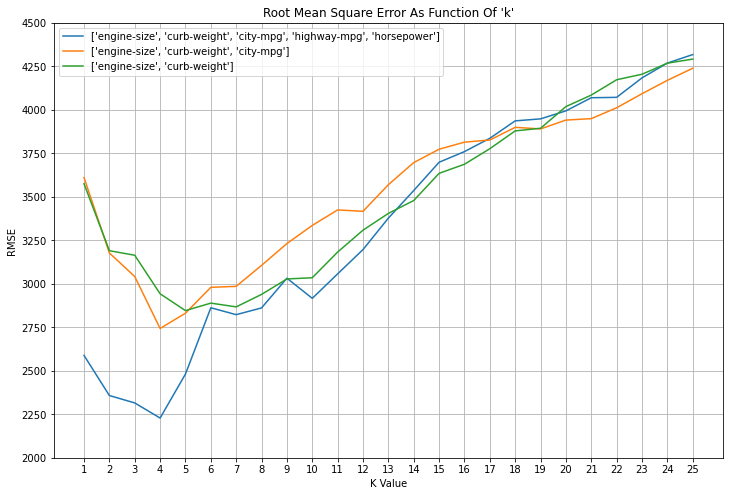

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title("Root Mean Square Error As Function Of 'k'")

for column in k_25.columns:
    ax.plot(k_25.index,
            k_25[column],
            label=column)

ax.set_yticks(np.arange(2000, 4500+250, 250))
ax.set_xlabel('K Value')
ax.set_ylabel('RMSE')
    
plt.legend(loc='upper left')

plt.grid()

plt.show()

The graph above reinforces the idea that setting 'k' at a low number - between 4 and 5, will in principle, maximize a model's accuracy. The blue line reinforces the idea that the 5 feature model is the most accurate model by far, when k is set at 4.


## Performing A K-fold Cross Validation For The Multivariate KNN Models
---
In order to get a better grasp on the models' prediction capabilities we can randomize our training and test sets several times over, assessing whether the average error is greater or smaller than the ones calculated earlier. To achieve this we'll use the k-fold approach, by setting the number of folds to 5.


Instead of doing manually all the pairings between 5 folders, in which each one of those folders (20% of the sample) will be set as the test set against the other 4 folders, which constitute the training set, we can use the scikit-learn `KFold` module. Since we are producing 5 different test and train sets' indexes, we need to transform the `knn_train_test_3` so that it takes those indexes as an input.

We set `shuffle=True` and `random_state=1` so that the sample is shuffled again and to have it memorized.

The process to arrive at the RMSEs is:
- Set the scikit-learn `KFold` module to randomize and memorize 5 instances of the training and test sets.
- Create `knn_train_test_4()` so that this version allows the input DataFrame to be split through the index, according to the randomized train and test indexes provided by the `KFold` setting.
- Create a function, `knn_k_fold_crossval()`, that goes to the process of fitting, predicting, and calculating the RMSE, 5 times for each model; and then returning the average RMSE. This function allows an integer as input so that we can change 'k'.

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

split = kf.split(cars_rand)

In [48]:
def knn_train_test_4(k, train_index, test_index, train_cols, target_col, df):
    """It takes a dataframe, test and train indexes, list of attributes/columns and a 
    target column, in order to perform a Multivariate K-nearest Neighbors prediction. 
    It returns the Root Mean Square Error between the target and the prediction.
    """

    columns = train_cols + [target_col]
    
    train = df[columns].copy()
    train = train.iloc[train_index, :].copy()
    
    
    test = df[columns].copy()
    test = test.iloc[test_index, :].copy()
    
    train_features = train[train_cols]
    train_target = train[target_col]

    knn = KNeighborsRegressor(n_neighbors=k, algorithm='auto')

    knn.fit(train_features, train_target)
    
    prediction = knn.predict(test[train_cols])
    
    mse = mean_squared_error(test[target_col], prediction)
    
    rmse = round(np.sqrt(mse), 2)
    
    return rmse    

In [49]:
def knn_k_fold_crossval(k):
    
    dictionary = {}
    
    for features in best_models:       
           
        rmse_list_kfold = []

        for train_index, test_index in kf.split(cars_rand):
            rmse = knn_train_test_4(k, train_index, test_index, features, 'price', cars_rand)
            rmse_list_kfold.append(rmse)

        mean_rmse = np.mean(rmse_list_kfold).round(2)

        dictionary[str(features)] = mean_rmse
        
    return dictionary

`knn_k_fold_crossval()` returns the mean RMSE for the models we have been exploring in the `best_models` list of best predicting features. The mean RMSE has been calculated from the 5 RMSEs produced by means of k-fold cross validation, by resorting to `knn_train_test_4()`. Since we have established that for these multivariate models the error is minimized when 'k' is set between 4 and 5, we present the cross-validation RMSEs for each case. 

In [50]:
top_5_kfold_rmse = knn_k_fold_crossval(5)

top_4_kfold_rmse = knn_k_fold_crossval(4)

compile_rmse = pd.DataFrame(
    {
        'Fixed sets, k=4': k_25.loc['4', :],
        'Fixed sets, k=5': k_25.loc['5', :],                     
        'K-folds, k=4': [top_5_kfold_rmse[key] for key in top_5_kfold_rmse],
        'K-folds, k=5': [top_4_kfold_rmse[key] for key in top_4_kfold_rmse]
    }
)

compile_rmse

,"Fixed sets, k=4","Fixed sets, k=5","K-folds, k=4","K-folds, k=5"
"['engine-size', 'curb-weight', 'city-mpg', 'highway-mpg', 'horsepower']",2228.60,2481.58,3125.60,2985.99
"['engine-size', 'curb-weight', 'city-mpg']",2743.48,2831.32,3204.48,3133.65
"['engine-size', 'curb-weight']",2942.93,2846.17,3108.09,3029.23


In general, the k-fold approach actually provides higher prediction errors compared with the initial fixed (single randomization) model. If we consider the most accurate models, the models with 5 attributes, we find a contradiction: the previous model (fixed) with `k=4` has a lower RMSE compared with the analogous version with `k=5`; inversely, if the randomized k-fold version with `k=5` has a smaller RMSE than its counterpart with `k=4`.



## Conclusion
---
From this analysis we can assess that a multivariate k-nearest neighbors model is, in principle, a more accurate tool in predicting our dependent variable - the car price; the most accurate univariate model - with the engine size as the predictor (RMSE = 3558.22, with k=7), is substantially less accurate than the best multivariate we've found - a model that includes engine size, curb weight, fuel consumption in city environment, fuel consumption in highway environment, and horsepower, as the predictors (RMSE = 2228.60, with k = 4): this model reduces the error in approx. 37% when compared with the former. Using K-folds cross validation considerably increases the error of the latter multivariate model (RMSE = 2985.99, k=5), but still shows an improvement over the best univariate model by approx. 16%.





\[end of project\]

\***